# Week 7 Practice

## Financial Time Series

### Data Import via yfinance

Install the yfinance package, which is the downloader connected with the Yahoo Fiannce API.

In [8]:
pip install pathlib #you might need this packge

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

C:\Users\yueya\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Download the data and save it as a pandas DataFrame.

In [3]:
# data=pd.read_csv("C:/Users/yueya/OneDrive - University of Westminster/2023-24/CMF/VOD.L.csv")

In [4]:
initial_data = yf.download("AAPL AMZN FB GOOG MSFT TSLA SPY ^VIX", start="2023-09-01", end="2024-09-01")

[*********************100%%**********************]  8 of 8 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [5]:
initial_data.head()

Price        Adj Close                                                      \
Ticker            AAPL        AMZN  FB        GOOG        MSFT         SPY   
Date                                                                         
2023-09-01  188.495453  138.119995 NaN  136.464874  326.211456  443.605408   
2023-09-05  188.734222  137.270004 NaN  136.375107  331.065033  441.688202   
2023-09-06  181.978806  135.360001 NaN  135.038361  330.399994  438.718964   
2023-09-07  176.656021  137.850006 NaN  135.866348  327.452148  437.372009   
2023-09-08  177.272858  138.229996 NaN  136.863876  331.779602  438.030731   

Price                               Close              ...        Open         \
Ticker            TSLA   ^VIX        AAPL        AMZN  ...        TSLA   ^VIX   
Date                                                   ...                      
2023-09-01  245.009995  13.09  189.460007  138.119995  ...  257.260010  13.56   
2023-09-05  256.489990  14.01  189.699997  137.270004  ...  245.000000  14.15   
2023-09-06  251.919998  14.45  182.910004  135.360001  ...  255.139999  14.27   
2023-09-07  251.490005  14.40  177.559998  137.850006  ...  245.070007  14.81   
2023-09-08  248.500000  13.84  178.179993  138.229996  ...  251.220001  14.22   

Price          Volume                                                         \
Ticker           AAPL      AMZN  FB      GOOG      MSFT       SPY       TSLA   
Date                                                                           
2023-09-01   45732600  40948300 NaN  16665700  14931200  58875700  132272500   
2023-09-05   45280000  40636700 NaN  17730200  18553900  55166200  129469600   
2023-09-06   81755800  41785500 NaN  15814300  17535800  70758500  116959800   
2023-09-07  112488800  48498900 NaN  16976000  18381000  70355400  115312900   
2023-09-08   65551300  38348200 NaN  17810700  19530100  61659700  118367700   

Price            
Ticker     ^VIX  
Date             
2023-09-01    0  
2023-09-05    0  
2023-09-06    0  
2023-09-07    0  
2023-09-08    0  

[5 rows x 48 columns]

In [6]:
initial_data['Adj Close'].head()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-01,188.495453,138.119995,NaN,136.464874,326.211456,443.605408,245.009995,13.09
2023-09-05,188.734222,137.270004,NaN,136.375107,331.065033,441.688202,256.489990,14.01
2023-09-06,181.978806,135.360001,NaN,135.038361,330.399994,438.718964,251.919998,14.45
2023-09-07,176.656021,137.850006,NaN,135.866348,327.452148,437.372009,251.490005,14.40
2023-09-08,177.272858,138.229996,NaN,136.863876,331.779602,438.030731,248.500000,13.84


Set the Adj Closed data as a new DataFrame we will use.

In [7]:
data =  initial_data['Adj Close']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-09-01 to 2024-08-30
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    251 non-null    float64
 1   AMZN    251 non-null    float64
 2   FB      0 non-null      float64
 3   GOOG    251 non-null    float64
 4   MSFT    251 non-null    float64
 5   SPY     251 non-null    float64
 6   TSLA    251 non-null    float64
 7   ^VIX    251 non-null    float64
dtypes: float64(8)
memory usage: 17.6 KB


In [8]:
data.head()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-01,188.495453,138.119995,NaN,136.464874,326.211456,443.605408,245.009995,13.09
2023-09-05,188.734222,137.270004,NaN,136.375107,331.065033,441.688202,256.489990,14.01
2023-09-06,181.978806,135.360001,NaN,135.038361,330.399994,438.718964,251.919998,14.45
2023-09-07,176.656021,137.850006,NaN,135.866348,327.452148,437.372009,251.490005,14.40
2023-09-08,177.272858,138.229996,NaN,136.863876,331.779602,438.030731,248.500000,13.84


In [9]:
data.tail()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2024-08-26,227.179993,175.500000,NaN,167.709229,413.489990,559.075134,213.210007,16.150000
2024-08-27,228.029999,173.119995,NaN,166.161270,413.839996,559.842834,209.210007,15.430000
2024-08-28,226.490005,170.800003,NaN,164.283737,410.600006,556.592773,205.750000,17.110001
2024-08-29,229.789993,172.119995,NaN,163.185181,413.119995,556.642578,206.279999,15.650000
2024-08-30,229.000000,178.500000,NaN,164.892944,417.140015,561.956299,214.110001,15.000000


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

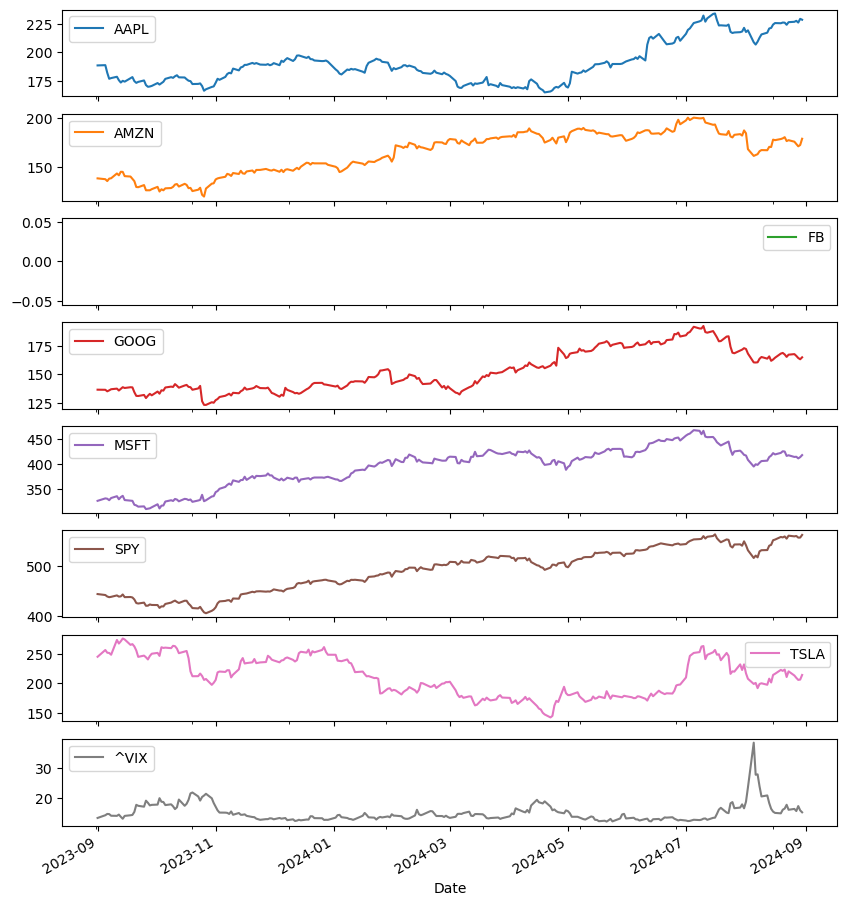

In [10]:
data.plot(figsize=(10, 12), subplots=True)

### Summary Statistics

In [11]:
data.describe().round(2)

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
count,251.00,251.00,0.0,251.00,251.00,251.00,251.00,251.00
mean,190.04,164.45,NaN,152.73,393.30,491.43,210.88,14.87
std,18.58,21.03,NaN,17.99,39.13,44.18,32.74,3.01
min,164.59,119.57,NaN,123.10,309.81,405.20,142.05,11.86
25%,174.75,146.23,NaN,137.75,368.89,449.77,180.00,12.93
50%,186.15,171.81,NaN,147.35,404.86,500.38,208.80,14.00
75%,195.40,181.50,NaN,168.52,420.03,526.30,240.76,15.87
max,234.55,200.00,NaN,192.41,466.72,563.13,276.04,38.57


### Changes over Time

There are multiple options to calculate the changes in a time series over time, including absolute differences, percentage changes, and logarithmic (log) returns.

First, the absolute differences, for which pandas provides a special method:

In [12]:
data.diff().head()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-05,0.238770,-0.849991,NaN,-0.089767,4.853577,-1.917206,11.479996,0.920000
2023-09-06,-6.755417,-1.910004,NaN,-1.336746,-0.665039,-2.969238,-4.569992,0.440000
2023-09-07,-5.322784,2.490005,NaN,0.827988,-2.947845,-1.346954,-0.429993,-0.050000
2023-09-08,0.616837,0.379990,NaN,0.997528,4.327454,0.658722,-2.990005,-0.559999


In [13]:
data.diff().describe().round(2)

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
count,250.00,250.00,0.0,250.00,250.00,250.00,250.00,250.00
mean,0.16,0.16,NaN,0.11,0.36,0.47,-0.12,0.01
std,2.70,2.90,NaN,2.65,4.92,3.85,7.18,1.53
min,-10.58,-16.17,NaN,-13.42,-15.92,-15.47,-30.39,-10.86
25%,-1.34,-1.47,NaN,-1.33,-2.50,-1.49,-4.09,-0.48
50%,0.32,0.06,NaN,0.54,0.63,0.53,0.05,-0.05
75%,1.50,1.83,NaN,1.55,3.82,2.85,3.55,0.39
max,14.01,12.53,NaN,15.70,10.72,11.95,25.76,15.18


From a statistics point of view, absolute changes are not optimal because they are dependent on the scale of the time series data itself. Therefore, percentage changes are usually preferred. The following code derives the percentage changes or percentage returns (also: simple returns) in a financial context and visualizes their mean values per column:

In [14]:
data.pct_change().round(4).head()

C:\Users\yueya\AppData\Local\Temp\ipykernel_17868\2305581467.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data.pct_change().round(4).head()


Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-05,0.0013,-0.0062,NaN,-0.0007,0.0149,-0.0043,0.0469,0.0703
2023-09-06,-0.0358,-0.0139,NaN,-0.0098,-0.0020,-0.0067,-0.0178,0.0314
2023-09-07,-0.0292,0.0184,NaN,0.0061,-0.0089,-0.0031,-0.0017,-0.0035
2023-09-08,0.0035,0.0028,NaN,0.0073,0.0132,0.0015,-0.0119,-0.0389


C:\Users\yueya\AppData\Local\Temp\ipykernel_17868\270052723.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data.pct_change().mean().plot(kind='bar', figsize=(10, 6));


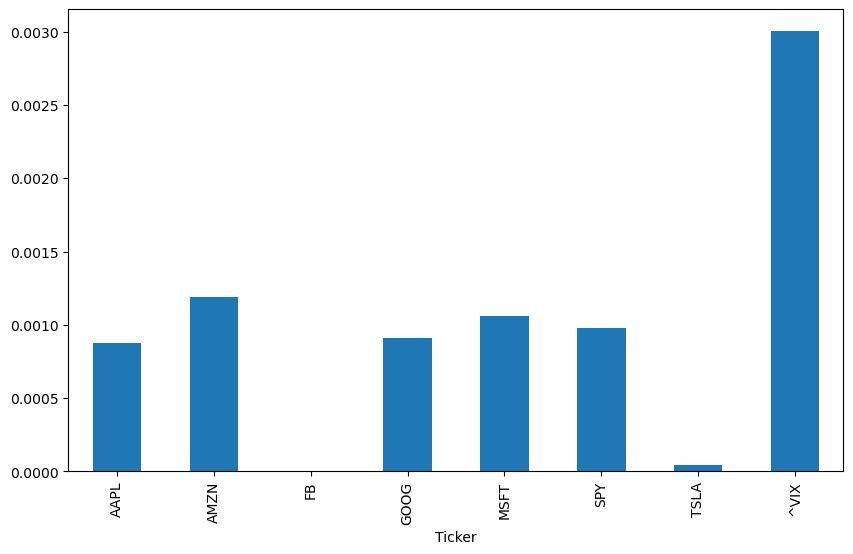

In [15]:
data.pct_change().mean().plot(kind='bar', figsize=(10, 6));

As an alternative to percentage returns, log returns can be used. In some scenarios, they are easier to handle and therefore often preferred in a financial context.

In [16]:
rets = np.log(data / data.shift(1))
rets.head().round(4)

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-05,0.0013,-0.0062,NaN,-0.0007,0.0148,-0.0043,0.0458,0.0679
2023-09-06,-0.0364,-0.0140,NaN,-0.0099,-0.0020,-0.0067,-0.0180,0.0309
2023-09-07,-0.0297,0.0182,NaN,0.0061,-0.0090,-0.0031,-0.0017,-0.0035
2023-09-08,0.0035,0.0028,NaN,0.0073,0.0131,0.0015,-0.0120,-0.0397


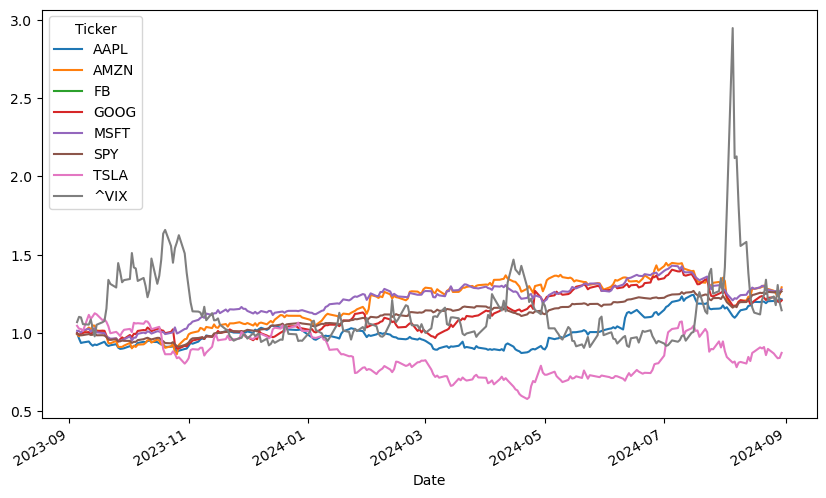

In [17]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6));

### Resampling

Resampling is an important operation on financial time series data. Usually this takes the form of downsampling, meaning that, for example, a tick data series is resampled to one-minute intervals or a time series with daily observations is resampled to one with weekly or monthly observations

In [20]:
data.resample('W', label='right').last().head()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-03,188.495453,138.119995,NaN,136.464874,326.211456,443.605408,245.009995,13.090000
2023-09-10,177.272858,138.229996,NaN,136.863876,331.779602,438.030731,248.500000,13.840000
2023-09-17,174.119019,140.389999,NaN,137.961197,327.759827,437.454498,274.390015,13.790000
2023-09-24,173.900131,129.119995,NaN,130.928467,314.648285,424.677307,244.880005,17.200001
2023-10-01,170.338364,127.120003,NaN,131.526993,313.397614,421.776520,250.220001,17.520000


Now we got an error, specifically, it is the 'TypeError'. We have to check the data type of the index for 'data'.

In [21]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [22]:
data.index = pd.to_datetime(data.index)
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [23]:
data.resample('W', label='right').last().head()

Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-03,188.495453,138.119995,NaN,136.464874,326.211456,443.605408,245.009995,13.090000
2023-09-10,177.272858,138.229996,NaN,136.863876,331.779602,438.030731,248.500000,13.840000
2023-09-17,174.119019,140.389999,NaN,137.961197,327.759827,437.454498,274.390015,13.790000
2023-09-24,173.900131,129.119995,NaN,130.928467,314.648285,424.677307,244.880005,17.200001
2023-10-01,170.338364,127.120003,NaN,131.526993,313.397614,421.776520,250.220001,17.520000


In [24]:
data.resample('M', label='right').last().head()

C:\Users\yueya\AppData\Local\Temp\ipykernel_17868\1797000683.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.resample('M', label='right').last().head()


Ticker,AAPL,AMZN,FB,GOOG,MSFT,SPY,TSLA,^VIX
Date,,,,,,,,
2023-09-30,170.338364,127.120003,NaN,131.526993,313.397614,421.776520,250.220001,17.520000
2023-10-31,169.900620,133.089996,NaN,124.993042,335.591003,412.620331,200.839996,18.139999
2023-11-30,189.231934,146.089996,NaN,133.591919,376.850372,450.310638,240.080002,12.920000
2023-12-31,191.802185,151.940002,NaN,140.584747,373.996002,470.869751,248.479996,12.450000
2024-01-31,183.702911,155.199997,NaN,141.452621,395.418915,478.369049,187.289993,14.350000


<Axes: xlabel='Date'>

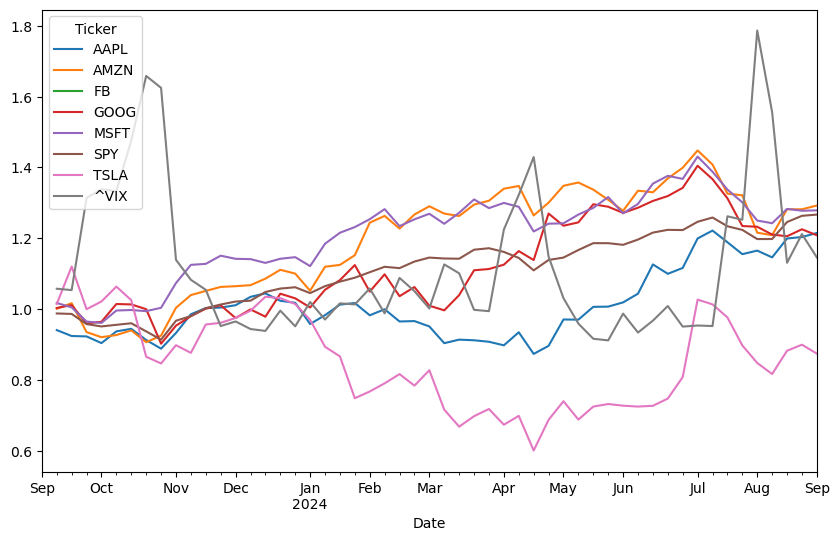

In [25]:
rets.cumsum().apply(np.exp). resample('W', label='right').last().plot(figsize=(10, 6))

We got the same TypeError. So it is likely that the data type of index for 'rets' is not DatetimeIndex, TimedeltaIndex or PeriodIndex either.

In [26]:
rets.index = pd.to_datetime(rets.index)
type(rets.index)

pandas.core.indexes.datetimes.DatetimeIndex

<Axes: xlabel='Date'>

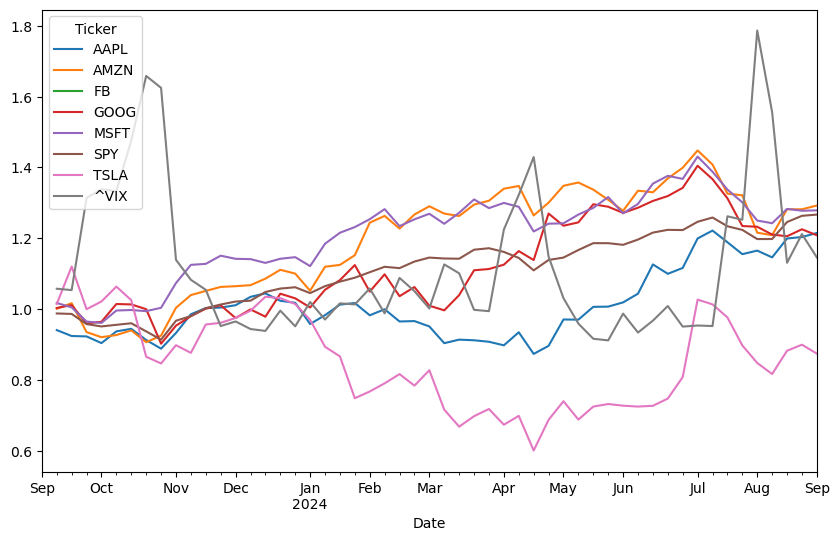

In [27]:
rets.cumsum().apply(np.exp). resample('W', label='right').last().plot(figsize=(10, 6))

C:\Users\yueya\AppData\Local\Temp\ipykernel_17868\1950779445.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rets.cumsum().apply(np.exp).resample('M', label='right').last().plot(figsize=(10, 6))


<Axes: xlabel='Date'>

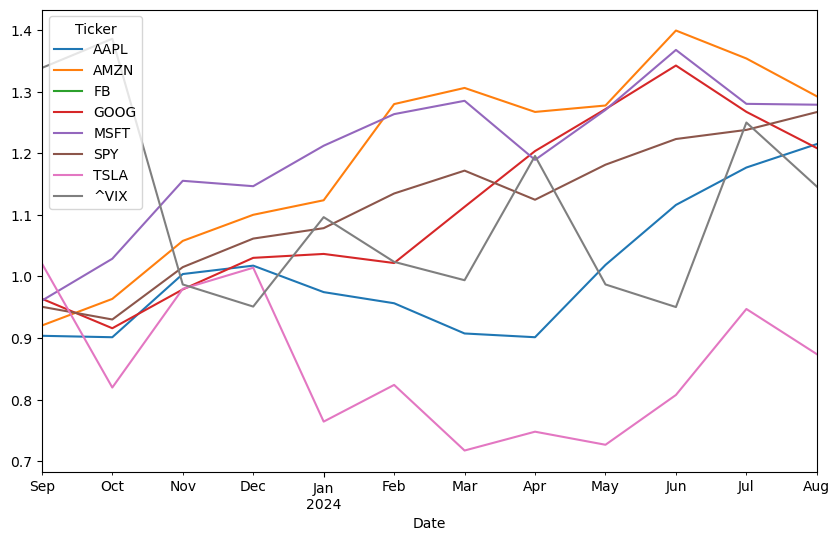

In [29]:
rets.cumsum().apply(np.exp).resample('M', label='right').last().plot(figsize=(10, 6))

### Rolling Statistics

It is financial tradition to work with rolling statistics, often also called financial indicators or financial studies. Such rolling statistics are basic tools for financial chartists and technical traders, for example. This section works with a single
financial time series only:

In [30]:
sym = 'AAPL'
AAPL_data = pd.DataFrame(data[sym]).dropna()
AAPL_data.tail()

,AAPL
Date,
2024-08-26,227.179993
2024-08-27,228.029999
2024-08-28,226.490005
2024-08-29,229.789993
2024-08-30,229.000000


In [31]:
window = 10
AAPL_data['min'] = data[sym].rolling(window=window).min()   #the rolling minimum.
AAPL_data['mean'] = data[sym].rolling(window=window).mean()
AAPL_data['std'] = data[sym].rolling(window=window).std()
AAPL_data['median'] = data[sym].rolling(window=window).median()
AAPL_data['max'] = data[sym].rolling(window=window).max()
AAPL_data['ewma'] = data[sym].ewm(halflife=0.5, min_periods=window).mean()
AAPL_data.dropna().head()

,AAPL,min,mean,std,median,max,ewma
Date,,,,,,,
2023-09-15,174.119019,173.323090,178.927409,5.664486,176.964439,188.734222,174.248951
2023-09-18,177.063950,173.323090,177.784259,4.565994,176.859985,188.734222,176.360200
2023-09-19,178.158356,173.323090,176.726672,2.509717,176.859985,181.978806,177.708817
2023-09-20,174.596573,173.323090,175.988449,1.769833,176.029236,178.446869,175.374634
2023-09-21,173.044495,173.044495,175.627296,1.975058,175.123878,178.446869,173.627029


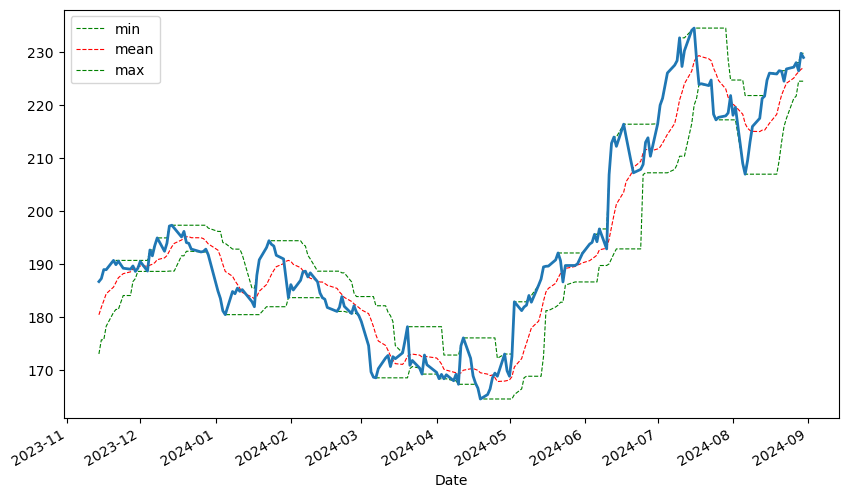

In [32]:
ax = AAPL_data[['min', 'mean', 'max']].iloc[-200:].plot(figsize=(10, 6), style=['g--', 'r--', 'g--'], lw=0.8)
data[sym].iloc[-200:].plot(ax=ax, lw=2.0);

Rolling statistics are a major tool in the so-called technical analysis of stocks, as compared to the fundamental analysis which focuses, for instance, on financial reports and the strategic positions of the company whose stock is being analysed.

A decades-old trading strategy based on technical analysis is using two simple moving averages (SMAs). The idea is that the trader should go long on a stock (or financial instrument in general) when the shorter-term SMA is above the longer-term SMA and should go short when the opposite holds true. The concepts can be made precise with pandas and the capabilities of the DataFrame
object.

Rolling statistics are generally only calculated when there is enough data given the window parameter specification.

In [33]:
AAPL_data['SMA1'] = data[sym].rolling(window=20).mean()
AAPL_data['SMA2'] = data[sym].rolling(window=60).mean()
AAPL_data[[sym, 'SMA1', 'SMA2']].tail()

,AAPL,SMA1,SMA2
Date,,,
2024-08-26,227.179993,220.068645,216.715944
2024-08-27,228.029999,220.542793,217.315982
2024-08-28,226.490005,220.776131,217.860721
2024-08-29,229.789993,221.360253,218.455132
2024-08-30,229.000000,221.829963,219.011073


<Axes: xlabel='Date'>

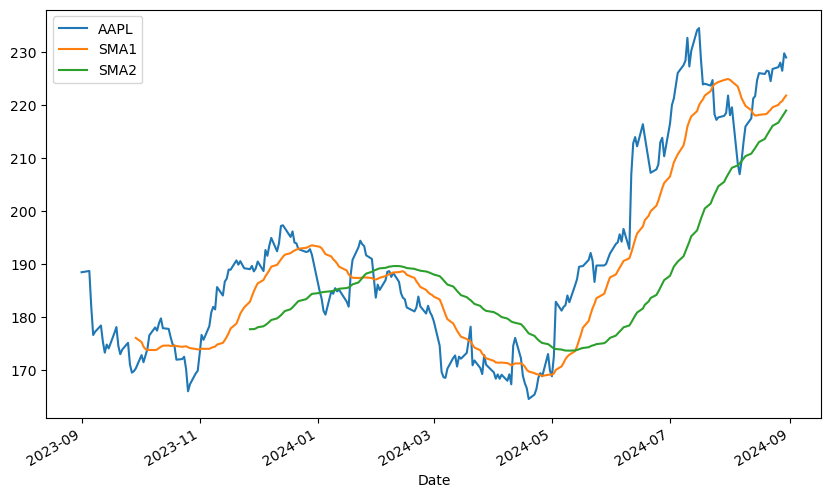

In [34]:
AAPL_data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6))

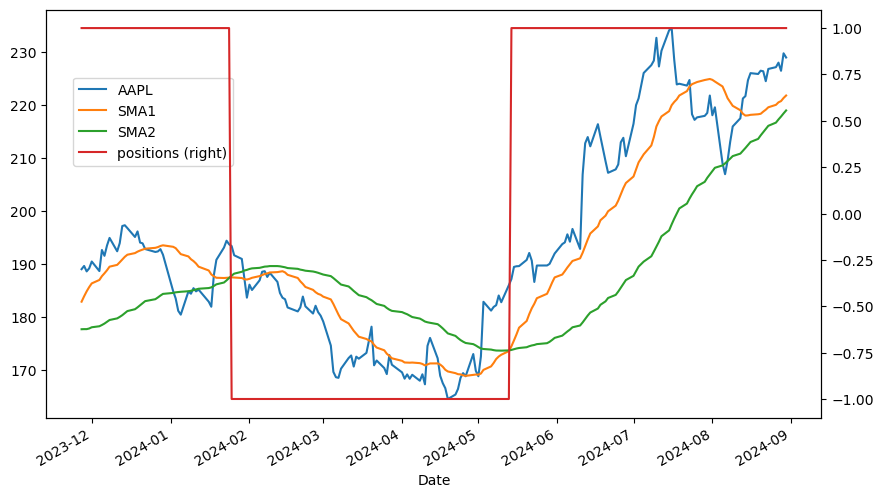

In [35]:
AAPL_data.dropna(inplace=True)
AAPL_data['positions'] = np.where(AAPL_data['SMA1'] > AAPL_data['SMA2'],1,-1)
ax = AAPL_data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(10, 6),secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

### Correlation Analysis

As a further illustration of how to work with pandas and financial time series data, consider the case of the S&P 500 stock index and the VIX volatility index.

It is a stylized fact that when the S&P 500 rises, the VIX falls in general, and vice versa. This is about correlation and not causation. This section shows how to come up with some supporting statistical evidence for the stylized fact that the S&P 500 and the VIX are (highly) negatively correlated.

In [36]:
Corr_data = data[['SPY', '^VIX']].dropna()
Corr_data.tail()

Ticker,SPY,^VIX
Date,,
2024-08-26,559.075134,16.150000
2024-08-27,559.842834,15.430000
2024-08-28,556.592773,17.110001
2024-08-29,556.642578,15.650000
2024-08-30,561.956299,15.000000


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

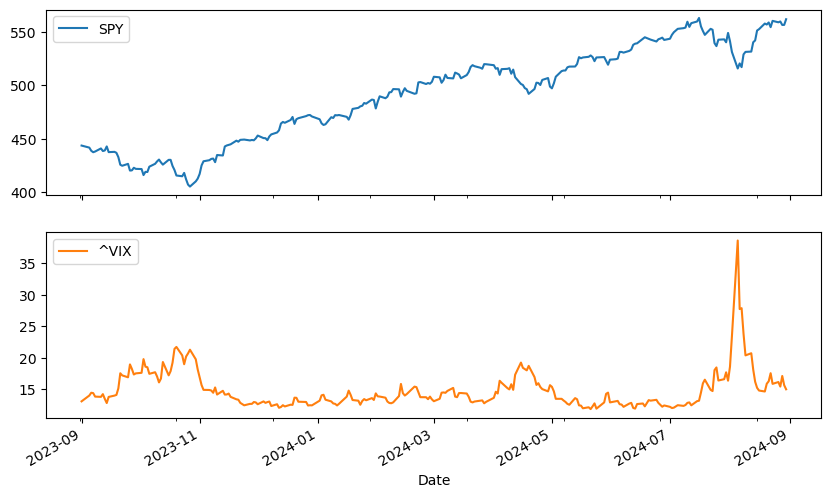

In [37]:
Corr_data.plot(subplots=True, figsize=(10, 6))

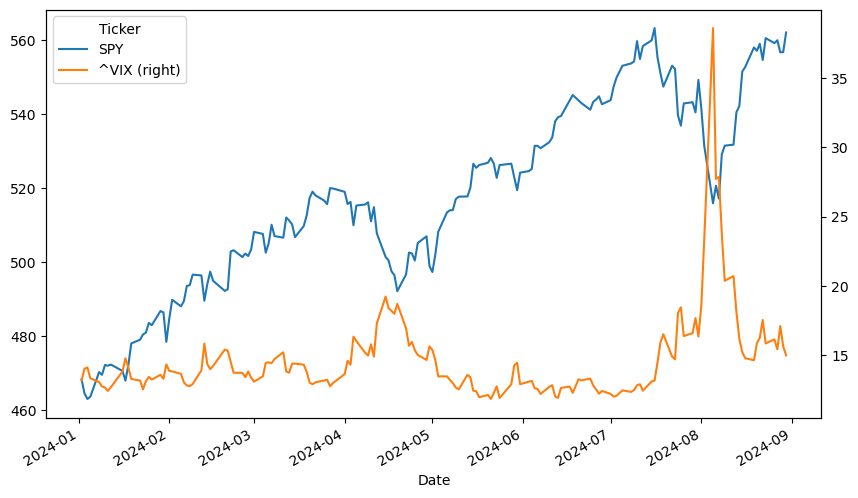

In [39]:
Corr_data.loc['2024-01-01':].plot(secondary_y='^VIX', figsize=(10, 6));

#### Logarithmic Returns

As pointed out earlier, statistical analysis in general relies on returns instead of absolute changes or even absolute values. Therefore, we’ll calculate log returns first before any further analysis takes place.

In [40]:
sprets = np.log(Corr_data / Corr_data.shift(1))
sprets.head()

Ticker,SPY,^VIX
Date,,
2023-09-01,NaN,NaN
2023-09-05,-0.004331,0.067923
2023-09-06,-0.006745,0.030923
2023-09-07,-0.003075,-0.003466
2023-09-08,0.001505,-0.039665


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

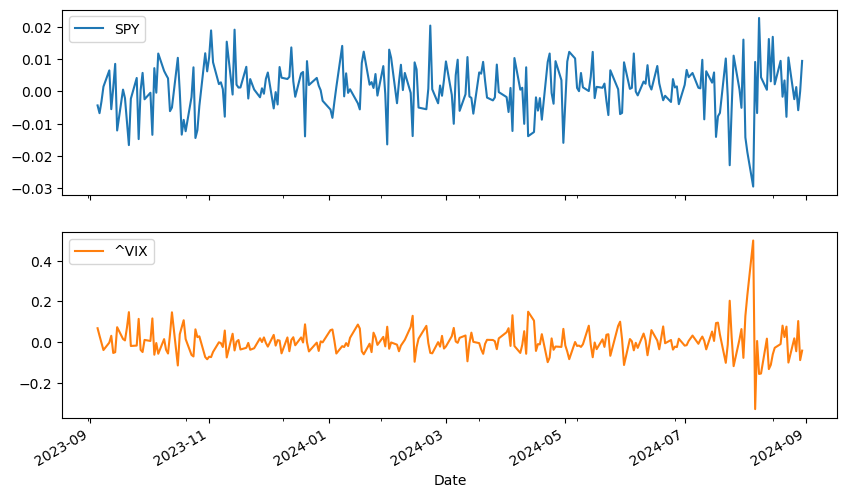

In [41]:
sprets.dropna(inplace=True)  #If True: the removing is done on the current DataFrame. 
#If False: returns a copy where the removing is done.
sprets.plot(subplots=True, figsize=(10, 6))

In such a context, the pandas scatter_matrix() plotting function comes in handy for visualizations. It plots the log returns of the two series against each other, and one can add either a histogram or a kernel density estimator (KDE) on the diagonal:

array([[<Axes: xlabel='SPY', ylabel='SPY'>,
        <Axes: xlabel='^VIX', ylabel='SPY'>],
       [<Axes: xlabel='SPY', ylabel='^VIX'>,
        <Axes: xlabel='^VIX', ylabel='^VIX'>]], dtype=object)

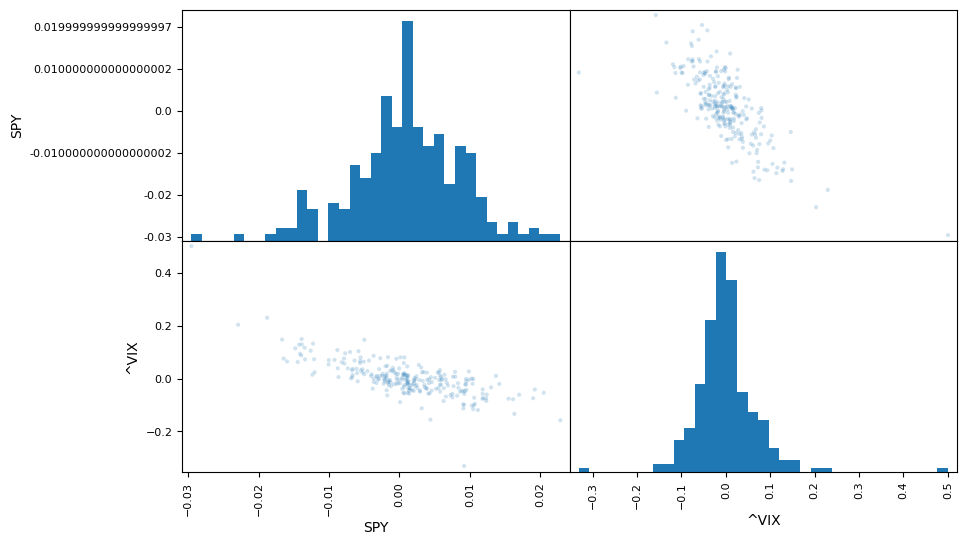

In [42]:
pd.plotting.scatter_matrix(sprets, alpha=0.2, diagonal='hist', hist_kwds={'bins': 35}, figsize=(10, 6))

#### OLS Regression

With all these preparations, an ordinary least-squares (OLS) regression analysis is convenient to implement.

array([-6.61760626,  0.00680476])

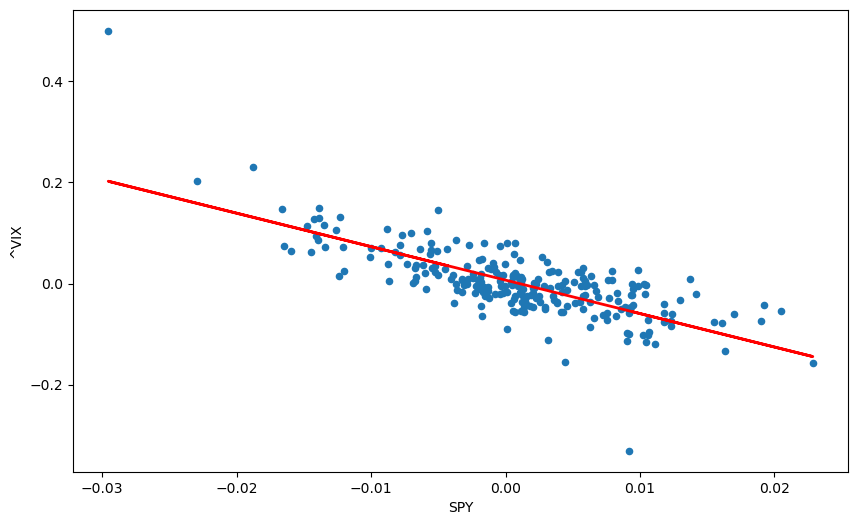

In [43]:
reg = np.polyfit(sprets['SPY'], sprets['^VIX'], deg=1) # Least squares polynomial fit. 'deg': the exponent of the indep variable
# Returns a vector of coefficients p that minimises the squared error 
ax = sprets.plot(kind='scatter', x='SPY', y='^VIX', figsize=(10, 6))
ax.plot(sprets['SPY'], np.polyval(reg, sprets['SPY']), 'r', lw=2); 
# np.polyval(p,x): Evaluate a polynomial at specific values. 'p' are parameters; 'x' are data (i.e. independent variables);
reg

#### Correlation

Finally, we consider correlation measures directly. Two such measures are considered: a static one taking into account the complete data set and a rolling one showing the correlation for a fixed window over time.

In [44]:
sprets.corr()

Ticker,SPY,^VIX
Ticker,,
SPY,1.00000,-0.74841
^VIX,-0.74841,1.00000


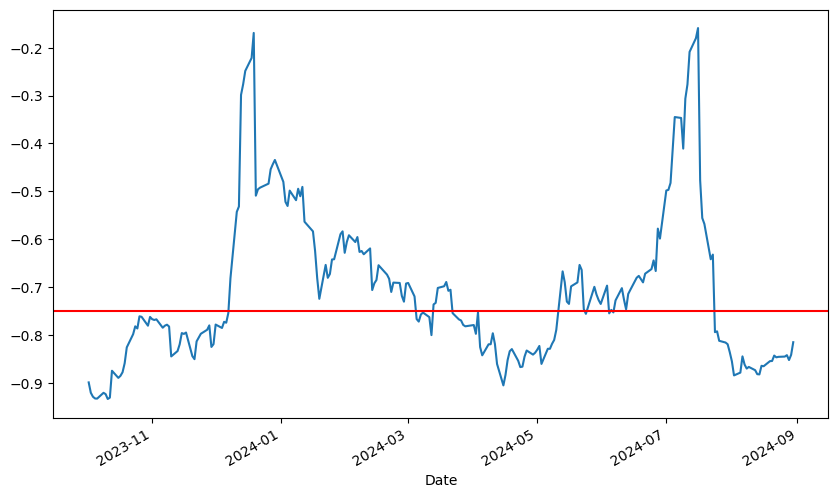

In [45]:
ax = sprets['SPY'].rolling(window=20).corr(sprets['^VIX']).plot(figsize=(10, 6))  #The rolling correlation.
ax.axhline(sprets.corr().iloc[0, 1], c='r');